<a href="https://colab.research.google.com/github/haneenbadr/Brain-Tumor-CT-SCAN-with-VGG16/blob/main/Brain_tumor_CT_SCAN_with_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (1).json to kaggle (1).json
User uploaded file "kaggle (1).json" with length 66 bytes
mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0
 98% 353M/361M [00:05<00:00, 60.4MB/s]
100% 361M/361M [00:05<00:00, 63.8MB/s]


In [3]:
from zipfile import ZipFile
file_name = "/content/brain-tumor-multimodal-image-ct-and-mri.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
import os
import shutil
import random


dataset_path = "/content/Dataset/Brain Tumor CT scan Images"
classes = ['Healthy', 'Tumor']


train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')


for dir_path in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(dir_path, cls), exist_ok=True)


for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.9 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, cls, img))


In [6]:
train_data =ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 3232 images belonging to 2 classes.
Found 924 images belonging to 2 classes.
Found 462 images belonging to 2 classes.


In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
   callbacks=[early_stopping]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 316ms/step - accuracy: 0.7997 - loss: 0.3950 - val_accuracy: 0.9405 - val_loss: 0.1590
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 56s 182ms/step - accuracy: 0.9634 - loss: 0.1188 - val_accuracy: 0.9524 - val_loss: 0.1478
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.9756 - loss: 0.0887 - val_accuracy: 0.9513 - val_loss: 0.1153
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.9797 - loss: 0.0655 - val_accuracy: 0.9697 - val_loss: 0.0994
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.9897 - loss: 0.0469 - val_accuracy: 0.9632 - val_loss: 0.0971
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.9919 - loss: 0.0359 - val_accuracy: 0.9632 - val_loss: 0.0961
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.9940 - loss: 0.0315 - val_accuracy: 0.9589 - val_loss: 0.1141
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.9979 - loss: 0.0197 - val

In [8]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step - accuracy: 0.9722 - loss: 0.1230
Test Accuracy: 0.97


In [9]:
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype("int32")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step
              precision    recall  f1-score   support

     Healthy       0.97      0.98      0.97       230
       Tumor       0.98      0.97      0.97       232

    accuracy                           0.97       462
   macro avg       0.97      0.97      0.97       462
weighted avg       0.97      0.97      0.97       462



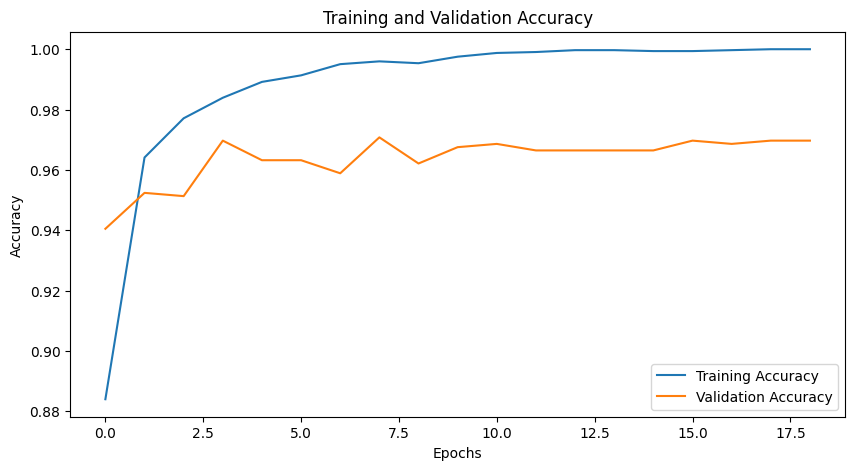

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

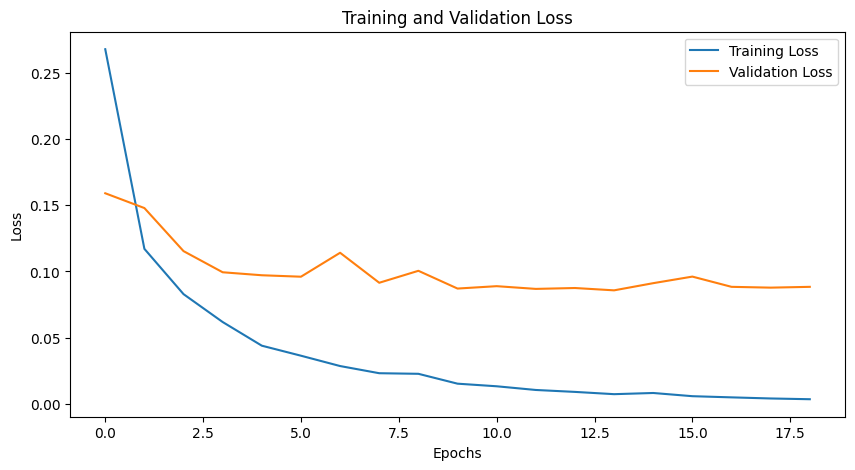

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

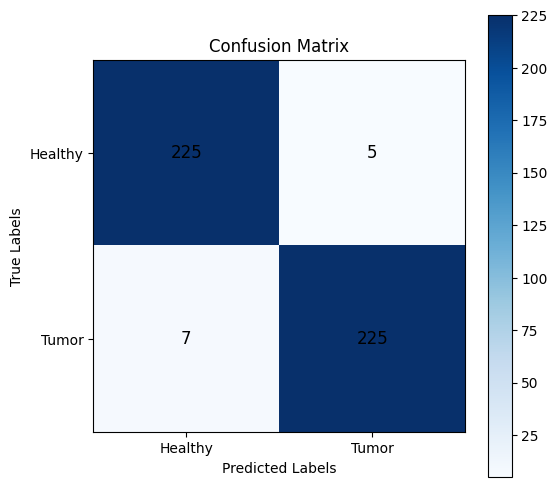

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], test_data.class_indices.keys())
plt.yticks([0, 1], test_data.class_indices.keys())


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

plt.show()



In [13]:
# استيراد TensorFlow
import tensorflow as tf

# التأكد من توفر GPU
print("Is GPU available:", tf.test.is_gpu_available())

# إنشاء بيانات كبيرة
a = tf.range(1e7, dtype=tf.float32)
b = tf.range(1e7, dtype=tf.float32)

# تنفيذ عملية الجمع على GPU
with tf.device('/GPU:0'):
    c = a + b

# طباعة أول 10 قيم
print(c[:10])


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is GPU available: True
tf.Tensor([ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.], shape=(10,), dtype=float32)
